# Tutorial for Tasks 2 and 3: Classification of frames
This notebook illustrates how to:
- define a Python fonction which produces solutions for tasks 2 or 3;
- run this function;
- evaluate its performance.

## Dataset loading
First, let us load the dataset. In this tutorial we use the complete version of the dataset, and we shuffle it to select random examples from the complete set. The `random_state` enables you to force the initialization the random number generator and reproduce the results.

In [1]:
from smartdoc15_ch1 import Dataset, Models, evaluate_classification

In [2]:
d = Dataset(shuffle=True, random_state=0)

We also load the models to read their images.

In [3]:
models = Models(variant=Models.VARIANT_05_SCALED33)

## Tasks definition
Tasks 2 and 3 are classification tasks.
Given a frame image, you should return:
- the class of the model for task 2: `0` if the frame contains an instance of "datasheet001", `1` for "datasheet002", ..., and `29` for "tax005"
- the class of the model type for task 3: `0` if the frame contains an instance of any "datasheet" model, `1` for "letter", `2` for "magazine", `3` for "paper", `4` for "patent" and `5` for "tax".

The following figures illustrate the expected outputs for tasks 2 and 3.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

### Expected outputs for Tasks 2 and 3

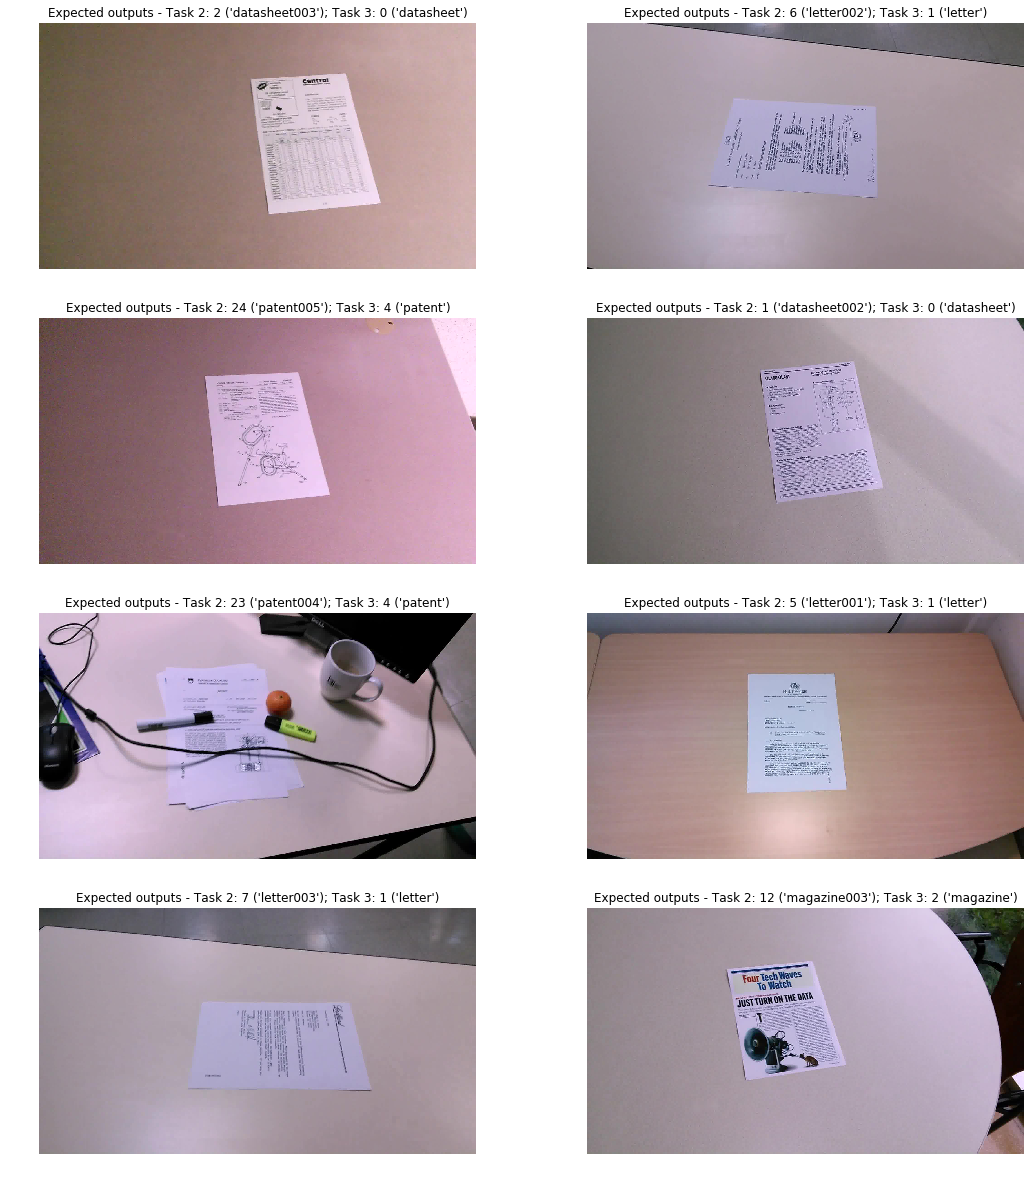

In [5]:
num_frames = 8
plt.figure(figsize=(18,2.6*num_frames))
for ii, frame in enumerate(d[:num_frames]):
    plt.subplot(num_frames//2,2,ii+1)
    plt.imshow(frame.read_image(color=True))
    plt.title("Expected outputs - Task 2: %d ('%s'); Task 3: %d ('%s')" 
              % (frame["model_id"], frame["model_name"], frame["modeltype_id"], frame["modeltype_name"]))
    plt.axis('off')
plt.show()

### Evaluation procedure

The evaluation function `evaluate_classification` is a very basic wrapper around scikit-learn metrics. You may want to compute classification performance using your own metrics to investigate your results better.
However, the evaluation function we provide is a simple and easy solution to estimate the performance of your approach. It requires:
- the target classification labels, which can be obtained using `Dataset.model_classif_targets` for task 2 or `Dataset.modeltype_classif_targets` for task 3;
- the predicted classification labels for all the frames, in the exact same order.

The correspondances between the model names (resp. model type names) and the model ids (resp. model type ids) are printed out below:

In [6]:
print("model_id : model_name")
print("-----------------------")
for model_id, model_name in zip(d.unique_model_ids, d.unique_model_names):
    print("%8d : %s" % (model_id, model_name))

model_id : model_name
-----------------------
       0 : datasheet001
       1 : datasheet002
       2 : datasheet003
       3 : datasheet004
       4 : datasheet005
       5 : letter001
       6 : letter002
       7 : letter003
       8 : letter004
       9 : letter005
      10 : magazine001
      11 : magazine002
      12 : magazine003
      13 : magazine004
      14 : magazine005
      15 : paper001
      16 : paper002
      17 : paper003
      18 : paper004
      19 : paper005
      20 : patent001
      21 : patent002
      22 : patent003
      23 : patent004
      24 : patent005
      25 : tax001
      26 : tax002
      27 : tax003
      28 : tax004
      29 : tax005


In [7]:
print("modeltype_id : modeltype_name")
print("-----------------------------")
for modeltype_id, modeltype_name in zip(d.unique_modeltype_ids, d.unique_modeltype_names):
    print("%12d : %s" % (modeltype_id, modeltype_name))

modeltype_id : modeltype_name
-----------------------------
           0 : datasheet
           1 : letter
           2 : magazine
           3 : paper
           4 : patent
           5 : tax


The signature of the function we have to code is therefore:

       np.array ---> integer
    input image |--> predicted classification label

## A simple frame classifier
We now define a simple function which makes use of OpenCV primitives to quickly classify a frame according to the detected model.

We use the ORB local descriptors, and "train" our "classifier" using the reduced model images.

You may need to install (locally) the Python wrapper for OpenCV by entering the following command in your shell:

    pip install opencv-python

In [8]:
import numpy as np
import cv2

We first create a local descriptor extractor, and a matcher. The first produced a set of (keypoint, descriptor) for each image, and the second indexes such data along with the source model id it was extracted from. The matcher will enable to look for each (keypoint, descriptor) couple extracted from a given image, and obtain the id of the most probable model. By gathering the correspondances between each (keypoint, descriptor) couple from the current frame and the model database, we can:
1. validate the geometrical consistency of the matches;
2. return the most probable model id for all the consistent matches we got.

In [9]:
detector = cv2.ORB_create(1000, 
                   scaleFactor=1.2, 
                   nlevels=25,
                   edgeThreshold=5,
                   firstLevel=0,
                   WTA_K=2,
                   scoreType=1,
                   patchSize=15)
matcher = cv2.FlannBasedMatcher({'algorithm': 6,
                                 'table_number': 6,
                                 'key_size': 12,
                                 'multi_probe_level': 1},
                                {})

Let us now read all the model images, detect the keypoints and compute their local descriptors, then the set of (keypoint, descriptor) in the matcher.

In [10]:
all_keypoints = []
for model_image in models.iter_model_images():
    keyp_mdli, desc_mdli = detector.detectAndCompute(model_image, mask=None)
    matcher.add([desc_mdli])  # associates all the descriptors to the next available index
#     all_keypoints.append(keyp_mdli)
    all_keypoints.extend(keyp_mdli)

In [11]:
len(all_keypoints)

29133

In [12]:
type(all_keypoints[2])

cv2.KeyPoint

In [13]:
all_keypoints[2].pt

(308.0, 79.0)

Now we prepare the classification function.
We pick an unused label for the rejection class.

In [14]:
reject_class = len(models)
reject_class

30

In [15]:
from collections import Counter

In [16]:
def detect_model(frame_image_gray, 
                 detector, 
                 matcher, 
                 model_keypoints,
                 num_of_matches=15, 
                 reject_class=reject_class):
    # First detect the keypoints in the frame
    (keyp_frame, desc_frame) = detector.detectAndCompute(frame_image_gray, None)

    # If not enough candidates for matching, reject
    if desc_frame is None or len(desc_frame) < num_of_matches:
        print("No or not enough descriptors.")
        return reject_class
    
    # Find candidate matches and the second nearest neighbor as well
    cmatches = matcher.knnMatch(desc_frame, k=2)
    
    # Compute how many time each model gets a good match
    # A good match is a match with a descriptor which is clearly closer than the second nearest one.
    # This is the ratio test proposed by D. Lowe.
    matches = [m[0] for m in cmatches if len(m) >= 2 and m[0].distance < m[1].distance * 0.75]
    
    # Determine winning model based on the number of good matches
    goodHits = Counter(m.imgIdx for m in matches)
    
    winners = goodHits.most_common(1)
    if len(winners) < 1:
        print("No winner for matches.")
        return reject_class
    
    # At least 1 candidate model, verify the geometric consistency
    # We consider only the most probable model in terms of hits.
    (mdlIdx, hits) = winners[0]
    print("Mdl candidate: %d" % mdlIdx)
    
    # Instead of re-running a dedicated matcher, we filter the good matches to keep
    # only descriptors from the candidate model
    matches_best = [m for m in matches if m.imgIdx == mdlIdx]
    
    # Reject if not enough matches for RANSAC
    if len(matches_best) < num_of_matches:
        print("Not enough keypoints for RANSAC.")
        return reject_class
    
    # Gather keypoint coordinates for RANSAC
    pt00 = [model_keypoints[m.trainIdx].pt for m in matches_best]
    pt10 = [keyp_frame[m.queryIdx].pt for m in matches_best]
    pt0, pt1 = np.float32(pt00), np.float32(pt10)
    H, ptmask = cv2.findHomography(pt0, pt1, cv2.RANSAC, 3.0)
    
    # Reject if not enough inliers
    if ptmask.sum() < num_of_matches:
        print("Not enough RANSAC inliers.")
        return reject_class
    
    # Enough inliers, validate the model id
    return mdlIdx

### Process some images and display the results
Let us now try our function on few images.

Mdl candidate: 2
Mdl candidate: 6
Mdl candidate: 24
Mdl candidate: 1
Mdl candidate: 10
Mdl candidate: 5
Mdl candidate: 7
Mdl candidate: 12


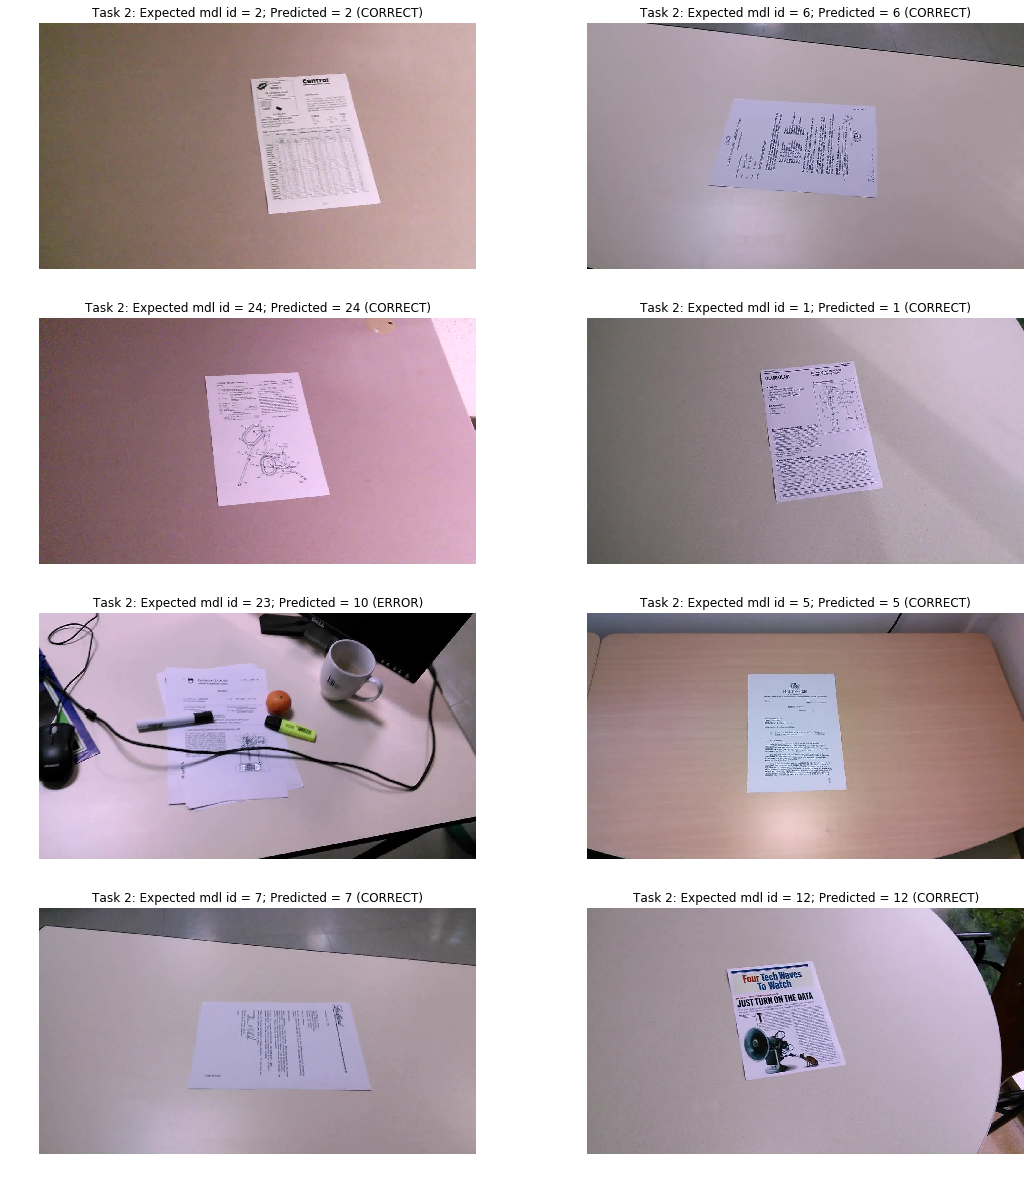

In [17]:
num_frames = 8
plt.figure(figsize=(18,2.6*num_frames))
for ii, frame in enumerate(d[:num_frames]):
    pred_model_label = detect_model(
                 frame.read_image(color=False), 
                 detector, 
                 matcher, 
                 model_keypoints=all_keypoints,
                 num_of_matches=4, 
                 reject_class=reject_class)
    correct_status = "CORRECT" if frame["model_id"] == pred_model_label else "ERROR"
    plt.subplot(num_frames//2,2,ii+1)
    plt.imshow(frame.read_image(color=True))
    plt.title("Task 2: Expected mdl id = %d; Predicted = %d (%s)" 
              % (frame["model_id"], pred_model_label, correct_status))
    plt.axis('off')
plt.show()

## Evaluating the performance on Task 2
Our document object detector seems to work (at least on this image). Let us now test it on the a sample of the dataset.

We will process all images and store the classification results, then we will call the evaluation function.

On the real dataset, you may want to parallelize such process, using the Joblib library for instance.

**The code in the two cells below is the only code you need (beside your function definition) to evaluate a given frame classification function.**

If you want to evaluate the performance of an external (non Python) program for this task, you will need to:
1. process the images in the canonical order of the dataset (see the "frames/metadata.csv.gz" file) and store results with this same order;
2. open and parse your result file(s) in Python produce a single list or array of `n` rows, `n` being the number of frames;
3. call the `evaluate_segmentation` function with the appropriate values.

In [18]:
sample_size = 200

In [19]:
predicted_labels = []
for ii, frame in enumerate(d[:sample_size]):
    print("Processing image %2d/%d: %s" % (ii+1, sample_size, frame["image_path"]))
    pred_model_label = detect_model(
             frame.read_image(color=False),
             detector, 
             matcher, 
             model_keypoints=all_keypoints,
             num_of_matches=4, 
             reject_class=reject_class)
    predicted_labels.append(pred_model_label)

Processing image  1/200: background03/datasheet003/frame_0032.jpeg
Mdl candidate: 2
Processing image  2/200: background04/letter002/frame_0043.jpeg
Mdl candidate: 6
Processing image  3/200: background03/patent005/frame_0008.jpeg
Mdl candidate: 24
Processing image  4/200: background02/datasheet002/frame_0115.jpeg
Mdl candidate: 1
Processing image  5/200: background05/patent004/frame_0053.jpeg
Mdl candidate: 10
Processing image  6/200: background01/letter001/frame_0111.jpeg
Mdl candidate: 5
Processing image  7/200: background04/letter003/frame_0053.jpeg
Mdl candidate: 7
Processing image  8/200: background02/magazine003/frame_0093.jpeg
Mdl candidate: 12
Processing image  9/200: background02/patent004/frame_0210.jpeg
Mdl candidate: 23
Processing image 10/200: background02/magazine001/frame_0012.jpeg
Mdl candidate: 10
Processing image 11/200: background02/tax002/frame_0001.jpeg
Mdl candidate: 26
Processing image 12/200: background04/letter005/frame_0001.jpeg
Mdl candidate: 9
Processing imag

Mdl candidate: 10
Processing image 100/200: background03/tax002/frame_0143.jpeg
Mdl candidate: 26
Processing image 101/200: background01/tax001/frame_0102.jpeg
Mdl candidate: 25
Processing image 102/200: background02/patent004/frame_0170.jpeg
Mdl candidate: 23
Processing image 103/200: background01/datasheet001/frame_0169.jpeg
Mdl candidate: 0
Processing image 104/200: background05/letter002/frame_0060.jpeg
Mdl candidate: 6
Processing image 105/200: background03/paper002/frame_0145.jpeg
Mdl candidate: 17
Processing image 106/200: background04/patent003/frame_0039.jpeg
Mdl candidate: 22
Processing image 107/200: background05/tax004/frame_0007.jpeg
Mdl candidate: 12
Processing image 108/200: background01/letter001/frame_0012.jpeg
Mdl candidate: 5
Processing image 109/200: background01/letter004/frame_0130.jpeg
Mdl candidate: 8
Processing image 110/200: background02/datasheet001/frame_0046.jpeg
Mdl candidate: 0
Processing image 111/200: background02/paper004/frame_0050.jpeg
Mdl candidate:

Mdl candidate: 18
Processing image 198/200: background01/letter005/frame_0154.jpeg
Mdl candidate: 9
Processing image 199/200: background02/patent001/frame_0009.jpeg
Mdl candidate: 20
Processing image 200/200: background04/letter002/frame_0072.jpeg
Mdl candidate: 6


We introduce a new class to identify rejected elements.

In [20]:
label_names = list(d.unique_model_names)

In [21]:
label_names.append("REJECT")
label_names

['datasheet001',
 'datasheet002',
 'datasheet003',
 'datasheet004',
 'datasheet005',
 'letter001',
 'letter002',
 'letter003',
 'letter004',
 'letter005',
 'magazine001',
 'magazine002',
 'magazine003',
 'magazine004',
 'magazine005',
 'paper001',
 'paper002',
 'paper003',
 'paper004',
 'paper005',
 'patent001',
 'patent002',
 'patent003',
 'patent004',
 'patent005',
 'tax001',
 'tax002',
 'tax003',
 'tax004',
 'tax005',
 'REJECT']

Note: the reject class introduces some errors in the results printed below as there are no expected element with the "REJECTED" label.

In [22]:
mean_accuracy, confusion_matrix = evaluate_classification(predicted_labels, d.model_classif_targets[:sample_size],
                                  label_names=label_names,
                                  print_summary=True)

              precision    recall  f1-score   support

datasheet001       1.00      1.00      1.00         7
datasheet002       1.00      0.88      0.93         8
datasheet003       0.88      1.00      0.93         7
datasheet004       1.00      1.00      1.00         7
datasheet005       1.00      0.75      0.86         4
   letter001       1.00      1.00      1.00         8
   letter002       1.00      0.75      0.86        12
   letter003       0.80      0.80      0.80         5
   letter004       1.00      1.00      1.00         7
   letter005       1.00      0.90      0.95        10
 magazine001       0.39      1.00      0.56         7
 magazine002       0.71      1.00      0.83         5
 magazine003       0.86      1.00      0.92         6
 magazine004       1.00      1.00      1.00         5
 magazine005       0.50      1.00      0.67         1
    paper001       1.00      0.29      0.44         7
    paper002       0.67      0.50      0.57         4
    paper003       0.67    

/home/jchazalo/.virtualenvs/sd15ch1_dev/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [23]:
mean_accuracy

0.85

## Check the results
We can now study which kind of input cause our function to perform well or not.

Let us simply plot the confusion matrix for this task.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools

In [25]:
# plot_confusion_matrix definition from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# BSD license
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

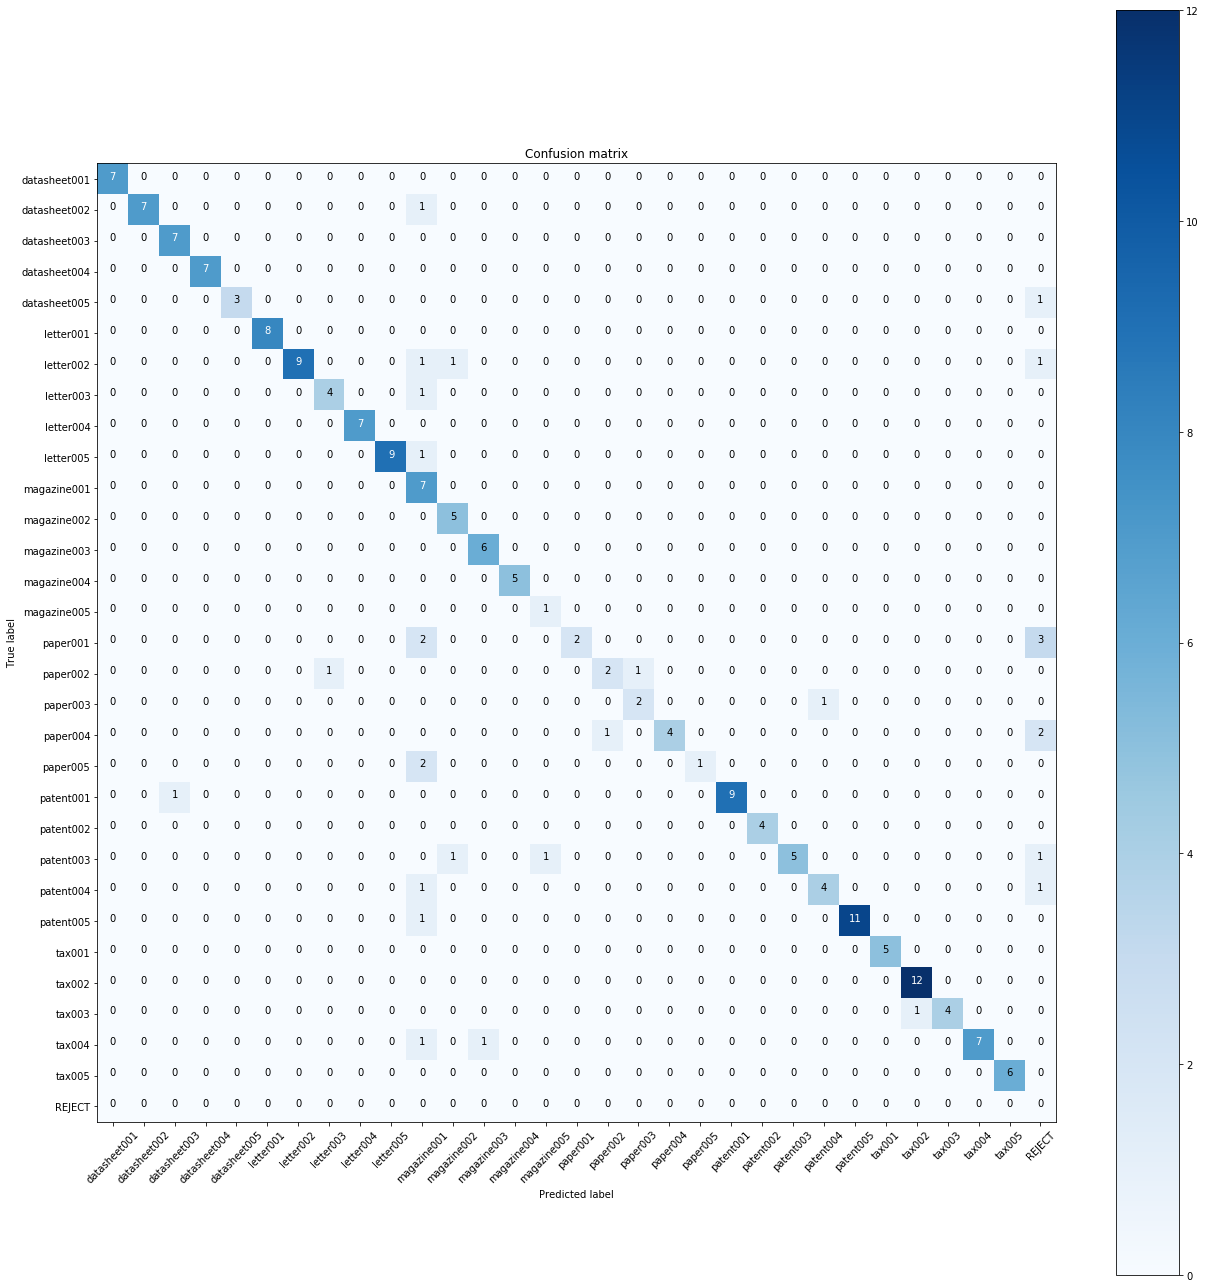

In [26]:
plt.figure(figsize=(18,18))
plot_confusion_matrix(confusion_matrix, classes=label_names,
                      title='Confusion matrix')
plt.show()

We can see in this sample that paper001 gets rejected more often, and that magazine001 seems to attract some confusion. Does it has more keypoints than other models?